In [1]:
import math
import itertools
from collections.abc import Iterable, Collection
from numbers import Number
from typing import Tuple, List, Union

import yaml

import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
data_file = 'data/laser_scan_1.yml'

In [3]:
with open(data_file, 'r') as f:
    scan_data = yaml.safe_load(f)

In [4]:
def point_cloud_to_np(scan_record):
    scan_points = np.array([ [point['x'], point['y']] for point in scan_record['points']] )
    scan_intensities = np.array([ channel['values'][0] for channel in scan_record['channels']])

    return scan_points, scan_intensities

In [5]:
scan_points, scan_intensities = point_cloud_to_np(scan_data)

In [6]:
print(f'{scan_points.shape=}, {scan_intensities.shape=}')

scan_points.shape=(234, 2), scan_intensities.shape=(234,)


In [7]:
def format_axes(ax: matplotlib.axes.Axes, suffix='', x_bounds = None, y_bounds = None):

    # Axis Labels
    if len(suffix.strip()) != 0:
        suffix = ' ' + suffix
    
    ax.set_xlabel(f'x{suffix}')
    ax.set_ylabel(f'y{suffix}')

    # Axis bounds
    ax.axis('equal')

    if x_bounds is not None:
        ax.set_xlim(*x_bounds)

    if y_bounds is not None:
        ax.set_ylim(*y_bounds)

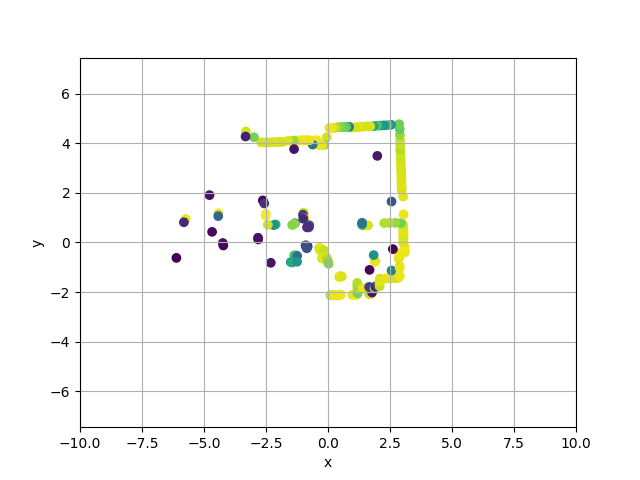

In [8]:
fig1 = plt.figure()
ax1 = fig1.gca()

ax1.scatter(scan_points[:,0], scan_points[:,1], c=scan_intensities)
ax1.grid()

format_axes(ax1, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [9]:
def points_to_distance_angle(points):

    r = np.sqrt(np.sum(np.power(points,2), axis=-1))
    theta = np.arctan2(points[:, 1], points[:, 0])

    return r, theta

In [ ]:
scan_r, scan_theta = points_to_distance_angle(scan_points)

In [11]:
def cluster_scan(scan_r, scan_theta, scan_points,
                max_neighbour_distance = 0.03, min_points = 5):

    # Sort point by angle
    scan_sorted_index = np.argsort(scan_theta)

    # scan_r_sorted = scan_r[scan_sorted_index]
    # scan_theta_sorted = scan_theta[scan_sorted_index]

    scan_points_sorted = scan_points[scan_sorted_index]

    scan_points_diff = np.roll(scan_points_sorted, 1, axis=0) - scan_points_sorted

    scan_points_diff_distance = np.sqrt(np.sum(np.power(scan_points_diff, 2), axis=-1))

    cluster_bound_index = np.concatenate(
        [
            [0],
            np.where(scan_points_diff_distance > max_neighbour_distance)[0],
            [len(scan_points_diff_distance)],
        ],
        axis=0,
    )

    cluster_bound_pair = np.stack(
        [cluster_bound_index[:-1], cluster_bound_index[1:]], axis=-1
    )

    # Loop baxck

    cluster_size = np.diff(cluster_bound_pair, axis=-1)[..., 0]

    valid_cluster_mask = cluster_size > min_points

    filtered_cluster_bound_pair = cluster_bound_pair[valid_cluster_mask]

    return scan_sorted_index, filtered_cluster_bound_pair

In [12]:
scan_sorted_indices, cluster_bound_pairs = cluster_scan(scan_r, scan_theta, scan_points, max_neighbour_distance=0.3, min_points=3)

In [13]:
scan_r_sorted = scan_r[scan_sorted_indices]
scan_theta_sorted = scan_theta[scan_sorted_indices]
scan_points_sorted = scan_points[scan_sorted_indices]

In [14]:
cluster_bound_pairs

array([[  3,  10],
       [ 17,  41],
       [ 41,  57],
       [ 57,  65],
       [ 65,  69],
       [ 69,  78],
       [ 79,  91],
       [ 92,  98],
       [104, 109],
       [110, 127],
       [128, 134],
       [136, 154],
       [155, 176],
       [177, 190],
       [191, 200],
       [203, 209],
       [209, 215],
       [217, 221]])

In [15]:
clusters = []
for cluster_bound in cluster_bound_pairs:
    lower_bound, upper_bound = cluster_bound
    clusters.append(scan_points_sorted.take(range(lower_bound,upper_bound), axis=0, mode='wrap'))

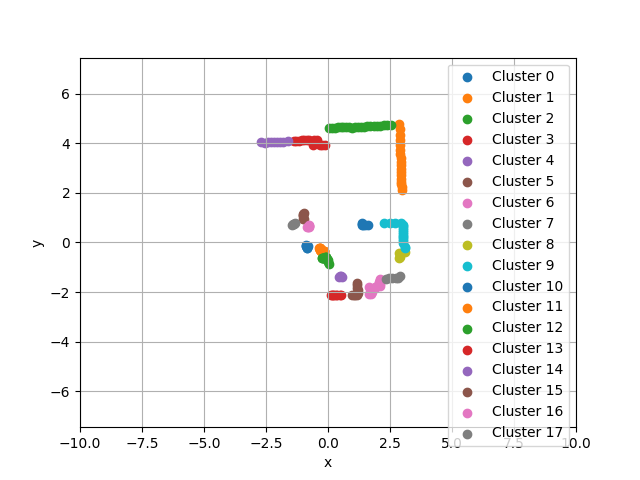

In [16]:
fig2 = plt.figure()
ax2 = fig2.gca()

for i, c in enumerate(clusters):
    ax2.scatter(c[:,0], c[:,1], label=f'Cluster {i}')
ax2.grid()
ax2.legend()
format_axes(ax2, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [17]:
cluster_bound_pairs[10]

array([128, 134])

In [18]:
scan_theta_sorted[128:134]

array([0.40294275, 0.42701483, 0.45108682, 0.47515885, 0.49923091,
       0.52330293])

In [19]:
# Fit line for each cluster

In [20]:
from dataclasses import dataclass
from typing import Dict, Set, List

@dataclass
class UnionFindNode:
    """ Class for keeping Union Find Node data"""
    value: int # Value of node
    parent: int # Parent node value
    rank: int # Higher bound on height

class UnionFind:
    def __init__(self):
        
        self.nodes : Dict[int, UnionFindNode] = {}
        self.roots : Set[int] = set()
        
    def make_set(self, x: int) -> None:
        if x not in self.nodes:
            self.nodes[x] = UnionFindNode(x, x, 0)
            self.roots.add(x)
        
    def find(self, x: int) -> int:
        """ Return root of set x belongs to. None if x does not exist in any set 
        
        Parameter
        ---------
        x: int
            id of node to get root of

        Return
        -------
        root: int
            id of root of set containing node id x
        
        """
        # Check if x exist in any set
        if x not in self.nodes:
            raise ValueError(f'Key {x} not found')
        
        # Search for root and path compression
        cur_node = self.nodes[x]
        while cur_node.parent != cur_node.value:
            parent_node = self.nodes[cur_node.parent]
            cur_node.parent = self.nodes[parent_node.parent].value # update to grand parent
            cur_node = parent_node
            
        return cur_node.value
        
    def union(self, x: int, y: int) -> None:
        a = self.nodes[self.find(x)]
        b = self.nodes[self.find(y)]
        
        if a.value != b.value:
            # Union if x and y is not part of same set
            if a.rank < b.rank:
                a,b = b,a # Swap to make a at least as large as b
                x,y = y,x

            b.parent = a.value # Re-parent
            
            # b is not root anymore
            # print(f'[Union {x},{y}] {a.value=} {b.value=} Set before: {self.roots}')
            self.roots.remove(b.value)
            # self.roots.remove(y)
            # print(f'[Union {x},{y}] {a.value=} {b.value=} Set After: {self.roots}')

            if a.rank == b.rank:
                a.rank += 1 # Re calculate rank
        
    def get_roots(self) -> Set[int]:
        return self.roots
    

In [21]:


def points_to_distance_angle(points):

    r = np.sqrt(np.sum(np.power(points,2), axis=-1))
    theta = np.arctan2(points[:, 1], points[:, 0])

    return r, theta

def fit_line(points: np.ndarray) -> np.ndarray:
    """Fit line to points. Require Length at least 2 distint points.
    
    Parameters
    ---------
    points: float np.ndarray[N,2]
        points to fit the line. Require at least 2 distinct points

    Returns
    --------
    slope_intercept: float np.ndarray[2, ]
        where slope_intercept = [a b] where y = ax + b

    Raise
    -------
    ValueError
        Not enough distinct points (<2) or singular A.T @ A
    
    """
    EPSILON = 1e-5

    n = len(points)
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    A = np.stack([points[:, 0], np.ones((n,))], axis=-1)

    ata = A.T @ A

    det = np.linalg.det(ata)
    if np.abs(det) < EPSILON:
        raise ValueError(f'Singular. Received {n} points. {points}')
    
    ata_inverse = np.linalg.inv(ata)

    # slope_intercept = [a b].T where y=ax+b
    slope_intercept = ata_inverse @ A.T @ np.expand_dims(points[:, 1], -1)

    return np.squeeze(slope_intercept)

def fit_line_uniform(points: np.ndarray, max_variance_threshold: float) -> np.ndarray:
    """Fit line to points. Require Length at least 2 distint points.
    
    Parameters
    ---------
    points: float np.ndarray[N,2]
        points to fit the line. Require at least 2 distinct points

    max_variance_threshold: float
        max variance accepted for point uniformity on the line. Threshold for varianceo of difference between consecutive points projected on the line

    Returns
    --------
    slope_intercept: float np.ndarray[2, ]
        where slope_intercept = [a b] where y = ax + b

    Raise
    -------
    ValueError
        Not enough distinct points (<2) or singular A.T @ A
    
    """
    EPSILON = 1e-5

    n = len(points)
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    A = np.stack([points[:, 0], np.ones((n,))], axis=-1)

    ata = A.T @ A

    det = np.linalg.det(ata)
    if np.abs(det) < EPSILON:
        raise ValueError(f'Singular. Received {n} points. {points}')
    
    ata_inverse = np.linalg.inv(ata)

    # slope_intercept = [a b].T where y=ax+b
    slope_intercept = ata_inverse @ A.T @ np.expand_dims(points[:, 1], -1)

    slope_intercept = np.squeeze(slope_intercept)

    parallel_distance, _ = get_point_line_parallel_perpendicular(points, *slope_intercept_to_vector_form(slope_intercept))

    parallel_distance_sorted = np.sort(parallel_distance)
    parallel_distance_sorted_diff = np.diff(parallel_distance_sorted)
    parallel_distance_sorted_diff_var = np.var(parallel_distance_sorted_diff)

    if np.any(parallel_distance_sorted_diff_var > max_variance_threshold):
        raise ValueError(f'Line not uniform enough. Max Variance: {np.max(parallel_distance_sorted_diff_var)}. Threshold: {max_variance_threshold}')

    return np.squeeze(slope_intercept)

def fit_line_ransac(points: np.ndarray,
                    fit_line_max_variance_threshold: float,
                    min_inlier_points: int,
                    sample_size: int,
                    inlier_distance_threshold: float,
                    inlier_proability: float,
                    success_probability: float = 0.95,
                    max_iterations: int = 10000
                    ) -> np.ndarray:

    iterations = int(math.ceil(math.log(1.0 - success_probability) / math.log(1.0 - inlier_proability ** sample_size)))
    iterations = min(max_iterations, iterations)

    data_n = len(points)

    best_inlier_count = min_inlier_points
    best_line_fit = None

    for i in range(iterations):

        # Sample random subset
        sample_index = np.random.choice(data_n, size=sample_size)
        sample_points = points[sample_index]

        # Fit line
        try:
            # line_slope_intercept = fit_line_uniform(sample_points, fit_line_max_variance_treshold)
            line_slope_intercept = fit_line(sample_points)
        except ValueError:
            # Error in line selection
            continue

        line_p, line_v_hat = slope_intercept_to_vector_form(line_slope_intercept)

        # Evaluate inliers
        parallel_distance, perpendicular_distance = get_point_line_parallel_perpendicular(points, line_p, line_v_hat)

        inlier_mask = perpendicular_distance < inlier_distance_threshold
        inlier_points = points[inlier_mask]

        inlier_count = np.sum(inlier_mask.astype(int))

        if inlier_count < best_inlier_count:
            continue

        inlier_parallel_distance = parallel_distance[inlier_mask]

        parallel_distance_sort_index = np.argsort(inlier_parallel_distance)
        parallel_distance_sorted = inlier_parallel_distance[parallel_distance_sort_index]

        parallel_distance_sorted_diff = np.diff(parallel_distance_sorted)
        parallel_distance_sorted_diff_var = np.var(parallel_distance_sorted_diff)

        if np.any(parallel_distance_sorted_diff_var > fit_line_max_variance_threshold):
            # Discard line, not uniform enough
            print(f'Not uniform enough. {np.max(parallel_distance_sorted_diff_var)} - {fit_line_max_variance_threshold}')
            continue

        if inlier_count >= best_inlier_count:
            # Refit line
            best_line_fit = fit_line(inlier_points)
            best_inlier_count = inlier_count

    # Return best
    return best_line_fit




def slope_intercept_to_vector_form(slope_intercept: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Convert line slope intercept form to vector form
    
    Parameters
    ----------
    slope_intercept: float np.ndarray[2, ]
        [slope, intercept]

    Returns
    -------
        p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction
        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line
    """

    # y = ax + b

    slope, intercept = slope_intercept

    v = np.array([[1.0, slope]])
    v_hat = v / np.expand_dims(np.linalg.norm(v), axis=-1)

    x = 0.0
    y = slope * x + intercept
    point_on_line = np.array([[x, y]])
    
    perpendicular_point = point_on_line - (np.sum(np.multiply(v_hat, point_on_line)))*v_hat

    return perpendicular_point, v_hat

def line_vector_form_from_line_segment(x_0: np.ndarray, x_1: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return line in vectorm form
    
    Parameters
    ----------
    x_0: float np.ndarray[1,2]
    x_1: float np.ndarray[1,2]

    Returns
    -------
    p: float np.ndarray[1,2]
        vector from origin to point on line. Perpedicular to v

    v: float np.ndarray[1,2]
        unit direction vector of line
    
    """

    EPSILON = 1e-6
    if x_0.shape != (1,2) or x_1.shape != (1,2):
        raise ValueError(f'Expected shaped (1,2) but received {x_0.shape=} and {x_1.shape=}')

    v = x_1 - x_0
    v_norm = np.linalg.norm(v)

    if v_norm < EPSILON:
        # Same point
        raise ValueError(f'Two points are the same/. {x_0=} {x_1=}')
    
    v_hat = v / v_norm
    
    perpendicular_point = x_0 - (np.sum(np.multiply(v_hat, x_0)))*v_hat
    
    return perpendicular_point, v_hat

def line_vector_to_hessian_form(p, v_hat):
    """Assuming p is already perpendicular point
    
    Returns
    -------
    line_hessian_form: float np.array[2,]
        Line in hessian normal form. [r, alpha] where r is distance from origin, alpha is angle from x [-pi, pi]
    
    """

    r = np.linalg.norm(p)
    alpha = np.arctan2(p[0,1], p[0,0])

    return np.array([r, alpha])

def get_point_line_parallel_perpendicular(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray) -> np.ndarray:
    """Get point parallel distance from p and (perpendicular) distance from line defined by position p and direction v_hat
    
    Parameters
    -----------
        points: float np.ndarray[N, 2]
            points to contain in line

        p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction

        v_hat: float np.ndarray[1, 2]
            normalized direction vector of line

    Returns
    -----------
        points_parallel_distance: float np.ndarray[N, ]
            Parallel distance of points to p

        points_perpendicular_distance: float np.ndarray[N, ]
            Perpendicular distance of points to line
    
    """

    line_to_points = points - p
    
    points_parallel_distance = np.sum(np.multiply(line_to_points, v_hat), axis=-1)

    line_to_point_project_normal = line_to_points - np.multiply(np.expand_dims(points_parallel_distance, -1), v_hat)

    points_perpendicular_distance = np.linalg.norm(line_to_point_project_normal, axis=-1)

    return points_parallel_distance, points_perpendicular_distance

def split_and_merge_points(scan_points: np.ndarray, inlier_distance_threshold: Number, merge_distance_threshold: Number, min_line_points: int = 10) -> List[np.ndarray]:
    """Split and merge algorithm
    
    1) Fit line to set
    2) 
    
    """

    def split(scan_points: np.ndarray, inlier_distance_threshold: Number) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Split subroutine.
        
        
        Returns
        --------
            lines: List[Tuple[float np.ndarray[2, ], np.ndarray[M, 2]]]
                list of tuple containing (line parameter, line points)

                line parameter: float np.ndarray[2, ]
                    Contains R, perpendicular distance from origin, and alpha, angle of normal of line to x axis

                line points: float np.ndarray[M, 2]
                    Points used to form the line
        
        """
        
        n = len(scan_points)
        if n < min_line_points:
            return []

        try:
            slope_intercept = fit_line(scan_points)
        except ValueError as e:
            # No line can be formed
            return []
        p1, v_hat1 = slope_intercept_to_vector_form(slope_intercept)

        points_parallel_distance_1, points_perpendicular_distance_1 = get_point_line_parallel_perpendicular(scan_points, p1, v_hat1)

        furthest_distance_index = np.argmax(points_perpendicular_distance_1)
        furthest_distance = points_perpendicular_distance_1[furthest_distance_index]

        if furthest_distance < inlier_distance_threshold:
            # Return line
            return [(p1, v_hat1, scan_points)]

        # Sort points
        point_sort_index = np.argsort(points_parallel_distance_1)
        scan_points_sorted = scan_points[point_sort_index]

        # Assume sorted points
        # Points can be sorted by arranging in order of increasing parallel distance
        first_point = np.expand_dims(scan_points_sorted[0], axis=0)
        last_point = np.expand_dims(scan_points_sorted[-1], axis=0)

        p2, v_hat2 = line_vector_form_from_line_segment(first_point, last_point)

        points_parallel_distance_2, points_perpendicular_distance_2 = get_point_line_parallel_perpendicular(scan_points_sorted, p2, v_hat2)

        furthest_distance_2_index = np.argmax(points_perpendicular_distance_2)

        lines = []

        try:
            first_split = split(scan_points_sorted[:furthest_distance_2_index], inlier_distance_threshold)
            lines.extend(first_split)
        except ValueError as e:
            pass
        
        try:
            second_split = split(scan_points_sorted[furthest_distance_2_index:], inlier_distance_threshold)
            lines.extend(second_split)
        except ValueError as e:
            pass

        return lines

    def merge(line_list, merge_distance_threshold: Number, inlier_distance_threshold: Number):
        """
        
        merge_distance_threshold: Number
            threshold to consider 2 line similar

        inlier_distance_threshold: Number
            threshold to consider for line segment forming
        """


        n = len(line_list)

        if n < 2:
            return []
        

        # N x 2
        lines_hessian = np.stack([line_vector_to_hessian_form(p, v_hat) for p,v_hat,_ in line_list], axis=0)

        # Symmetric
        
        line_hessian_difference = np.expand_dims(lines_hessian, axis=1) - np.expand_dims(lines_hessian, axis=0)

        # TODO: Get min angle instead
        angle_difference = line_hessian_difference[..., -1]
        angle_difference_abs = np.abs(angle_difference)
        line_hessian_difference[..., -1] = np.minimum(angle_difference_abs, 2*math.pi - angle_difference_abs) # Since will be squared anyways

        line_hessian_difference_2 = np.power(line_hessian_difference, 2)

        similar_line_matrix = np.sum(line_hessian_difference_2,axis=-1) <= merge_distance_threshold


        # Form N sets
        disjoint_sets = UnionFind()
        for i in range(n):
            disjoint_sets.make_set(i)

        for i in range(n):
            for j in range(n):
                if(j >= i):
                    # Skip half triangle
                    break

                # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=}')
                if similar_line_matrix[j,i]:
                    # Combine sets
                    # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=} Pass')
                    disjoint_sets.union(i,j)

        set_roots = disjoint_sets.get_roots()

        lines = []
        for root in set_roots:

            point_set = []
            set_size = 0
            for i in range(n):
                if similar_line_matrix[root][i]:
                    point_set.append(line_list[i][-1])
                    set_size += 1

            point_set = np.concatenate(point_set, axis=0)

            # print(f'{root=} {set_size}')

            p, v_hat = line_list[root][:-1]

            if set_size > 1:
                # Fit line to point set
                line_slope_intercept = fit_line(point_set)
                p, v_hat = slope_intercept_to_vector_form(line_slope_intercept)
            line_segment = line_to_segment(point_set, p, v_hat, inlier_distance_threshold)

            if line_segment is None:
                continue

            lines.append((line_segment, point_set))

        return lines

    line_list = split(scan_points, inlier_distance_threshold)
    
    refined_line_list = merge(line_list, merge_distance_threshold, inlier_distance_threshold)

    return refined_line_list

def split_and_merge_points_ransac(scan_points: np.ndarray, 
                                  inlier_distance_threshold: Number, 
                                  merge_distance_threshold: Number, 
                                  fit_line_max_variance_thresold: Number,
                                  ransac_inlier_distance_threshold: Number,
                                  min_line_points: int = 10,
                                  ransac_inlier_probability: Number = 0.8,
                                  ransac_success_probability: Number = 0.95,
                                  ransac_sample_size: int = 5,
                                  ransac_max_iterations: int = 10000
                                  ) -> List[np.ndarray]:
    """Split and merge algorithm
    
    1) Fit line to set
    2) 
    
    """

    def split(scan_points: np.ndarray, inlier_distance_threshold: Number) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Split subroutine.
        
        
        Returns
        --------
            lines: List[Tuple[float np.ndarray[2, ], np.ndarray[M, 2]]]
                list of tuple containing (line parameter, line points)

                line parameter: float np.ndarray[2, ]
                    Contains R, perpendicular distance from origin, and alpha, angle of normal of line to x axis

                line points: float np.ndarray[M, 2]
                    Points used to form the line
        
        """
        
        n = len(scan_points)
        if n < min_line_points:
            return []

        try:
            # slope_intercept = fit_line(scan_points)
            slope_intercept = fit_line_ransac(scan_points,
                            fit_line_max_variance_threshold=fit_line_max_variance_thresold,
                            min_inlier_points=min_line_points,
                            sample_size=ransac_sample_size,
                            inlier_distance_threshold=ransac_inlier_distance_threshold,
                            inlier_proability=ransac_inlier_probability,
                            success_probability=ransac_success_probability, max_iterations=ransac_max_iterations)
        except ValueError as e:
            # No line can be formed
            return []
        
        if slope_intercept is None:
            # No line found
            
            return []
        p1, v_hat1 = slope_intercept_to_vector_form(slope_intercept)

        points_parallel_distance_1, points_perpendicular_distance_1 = get_point_line_parallel_perpendicular(scan_points, p1, v_hat1)

        furthest_distance_index = np.argmax(points_perpendicular_distance_1)
        furthest_distance = points_perpendicular_distance_1[furthest_distance_index]

        if furthest_distance < inlier_distance_threshold:
            # Return line
            return [(p1, v_hat1, scan_points)]

        # Sort points
        point_sort_index = np.argsort(points_parallel_distance_1)
        scan_points_sorted = scan_points[point_sort_index]

        # Assume sorted points
        # Points can be sorted by arranging in order of increasing parallel distance
        first_point = np.expand_dims(scan_points_sorted[0], axis=0)
        last_point = np.expand_dims(scan_points_sorted[-1], axis=0)

        p2, v_hat2 = line_vector_form_from_line_segment(first_point, last_point)

        points_parallel_distance_2, points_perpendicular_distance_2 = get_point_line_parallel_perpendicular(scan_points_sorted, p2, v_hat2)

        furthest_distance_2_index = np.argmax(points_perpendicular_distance_2)

        lines = []

        try:
            first_split = split(scan_points_sorted[:furthest_distance_2_index], inlier_distance_threshold)
            lines.extend(first_split)
        except ValueError as e:
            pass
        
        try:
            second_split = split(scan_points_sorted[furthest_distance_2_index:], inlier_distance_threshold)
            lines.extend(second_split)
        except ValueError as e:
            pass

        return lines

    def merge(line_list, merge_distance_threshold: Number, inlier_distance_threshold: Number):
        """
        
        merge_distance_threshold: Number
            threshold to consider 2 line similar

        inlier_distance_threshold: Number
            threshold to consider for line segment forming
        """


        n = len(line_list)

        if n < 2:
            return []
        

        # N x 2
        lines_hessian = np.stack([line_vector_to_hessian_form(p, v_hat) for p,v_hat,_ in line_list], axis=0)

        # Symmetric
        
        line_hessian_difference = np.expand_dims(lines_hessian, axis=1) - np.expand_dims(lines_hessian, axis=0)

        # TODO: Get min angle instead
        angle_difference = line_hessian_difference[..., -1]
        angle_difference_abs = np.abs(angle_difference)
        line_hessian_difference[..., -1] = np.minimum(angle_difference_abs, 2*math.pi - angle_difference_abs) # Since will be squared anyways

        line_hessian_difference_2 = np.power(line_hessian_difference, 2)

        similar_line_matrix = np.sum(line_hessian_difference_2,axis=-1) <= merge_distance_threshold


        # Form N sets
        disjoint_sets = UnionFind()
        for i in range(n):
            disjoint_sets.make_set(i)

        for i in range(n):
            for j in range(n):
                if(j >= i):
                    # Skip half triangle
                    break

                # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=}')
                if similar_line_matrix[j,i]:
                    # Combine sets
                    # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=} Pass')
                    disjoint_sets.union(i,j)

        set_roots = disjoint_sets.get_roots()

        lines = []
        for root in set_roots:

            point_set = []
            set_size = 0
            for i in range(n):
                if similar_line_matrix[root][i]:
                    point_set.append(line_list[i][-1])
                    set_size += 1

            point_set = np.concatenate(point_set, axis=0)

            # print(f'{root=} {set_size}')

            p, v_hat = line_list[root][:-1]

            if set_size > 1:
                # Fit line to point set
                # line_slope_intercept = fit_line(point_set)

                line_slope_intercept = fit_line_ransac(scan_points,
                            fit_line_max_variance_threshold=fit_line_max_variance_thresold,
                            min_inlier_points=min_line_points,
                            sample_size=ransac_sample_size,
                            inlier_distance_threshold=ransac_inlier_distance_threshold,
                            inlier_proability=ransac_inlier_probability,
                            success_probability=ransac_success_probability, max_iterations=ransac_max_iterations)
                
                if line_slope_intercept is None:
                    # Failed to merge
                    print(f'Failed to merge set.')
                    continue

                p, v_hat = slope_intercept_to_vector_form(line_slope_intercept)
            line_segment = line_to_segment(point_set, p, v_hat, inlier_distance_threshold)

            if line_segment is None:
                continue

            lines.append((line_segment, point_set))

        return lines

    line_list = split(scan_points, inlier_distance_threshold)
    
    refined_line_list = merge(line_list, merge_distance_threshold, inlier_distance_threshold)

    return refined_line_list


def line_to_segment(points: np.ndarray, p: np.ndarray, v_hat: np.ndarray, inlier_distance_threshold: Number) -> Union[None, np.ndarray]:
    """Convert line to line segments given points and slope_intercept parameters. Convert to (x1, y1) , (x2, y2)

    Parameters
    ---------
    points: float np.ndarray[N, 2]
        points to contain in line

    p: float np.ndarray[1, 2]
            position vector of point on line, orthogonal to direction

    v_hat: float np.ndarray[1, 2]
        normalized direction vector of line

    inlier_distance_threshold: Number
        shortest distance to line to consider inliers

    Returns
    --------
    bounds: float np.ndarray[2, 2]
        bounds array. bounds = [[x1, y1], [x2, y2]].
        Return None if no inlier found

    """

    # Len of points must be at least 2
    n = len(points)
    
    if n < 2:
        raise ValueError(f'Required at least 2 points. Received {n} points. {points}')

    points_parallel_distance, points_perpendicular_distance = get_point_line_parallel_perpendicular(points, p, v_hat)

    inlier_masks = points_perpendicular_distance < inlier_distance_threshold

    n_inliers = np.sum(inlier_masks.astype(int))
    if n_inliers < 2:
        return None

    inlier_line_project_magnitude = points_parallel_distance[inlier_masks]

    sorted_points_index = np.argsort(inlier_line_project_magnitude)

    first_point_magnitude = inlier_line_project_magnitude[sorted_points_index[0]]
    last_point_magnitude = inlier_line_project_magnitude[sorted_points_index[-1]]

    first_line_end = p + first_point_magnitude * v_hat
    last_line_end = p + last_point_magnitude * v_hat

    return np.concatenate([first_line_end, last_line_end], axis=0)

def line_line_intersection(
        p1: np.ndarray,
        v1: np.ndarray,
        p2: np.ndarray,
        v2: np.ndarray,
        angle_limit_radians: float = math.pi * 2/180, epsilon=1e-5):
    """ Get line-line intersection

    Parameters
    ---------
    p1: float np.ndarray[1, 2]
        position vector to point on line 1
    v1: float np.ndarray[1, 2]
        direction vector of line 1

    p2: float np.ndarray[1, 2]
        position vector to point on line 2
    v2: float np.ndarray[1, 2]
        direction vector of line 2

    angle_limit_radians: float
        Max angle different in randians between v1 and v2 to consider them to not intersect
    
        
    epsilon: float
        use to check errors between line 1 and line 2 calculations for consistency

    Returns
    ---------
    intersection point: float np.ndarray[1, 2]
        Intersection point. Return None if line is parallel (not intersecting) or result inconsistent
    """

    v1_norm = np.linalg.norm(v1)
    if v1_norm < epsilon:
        raise ValueError(f'v1 has zero norm - {v1_norm}. v1: {v1}')
    v1_unit = v1 / v1_norm

    v2_norm = np.linalg.norm(v2)
    if v2_norm < epsilon:
        raise ValueError(f'v2 has zero norm - {v2_norm}. v2: {v2}')
    v2_unit = v2 / v2_norm

    direction_cross = np.cross(v1_unit, v2_unit)
    direction_dot = np.sum(np.multiply(v1_unit, v2_unit))

    angle_difference = np.arctan2(direction_cross, direction_dot)

    if abs(angle_difference) < angle_limit_radians:
        # Line too similar
        return None
    
    # 2 x 1
    b = p1.T - p2.T

    # 2 x 2
    A = np.concatenate([-v1.T, v2.T], axis=1)

    x = np.matmul(np.linalg.inv(A), b)

    #Check
    k1 = x[0,0]
    k2 = x[1,0]
    
    point_line1 = k1*v1 + p1
    point_line2 = k2*v2 + p2

    if np.linalg.norm(point_line1-point_line2) > epsilon:
        return None

    return (point_line1 + point_line2) / 2

def get_corner_points_lines(line_list, distance_threshold):
    """
    Parameters
    ---------
    lines:  List[Tuple[float np.ndarray[2, 2], float np.ndarray[N, 2]]]
        list of tuple of line segment (2 end points) and point set defining the line segment
    """

    # M lines
    # Find minimum distance between endpoints
    # O(m^2)
    # 2 * 2 * M^2
    # Expensive but assuming # lines in line set is small

    M = len(line_list)
    if M < 2:
        return []
    lines, point_sets = list(zip(*line_list))

    # 2*M x 2
    lines_packed = np.concatenate(lines, axis=0)

    # 2*M x 2*M
    end_point_distances = np.sqrt(np.sum(np.power(np.expand_dims(lines_packed, axis=1) - np.expand_dims(lines_packed, axis=0),2), axis=-1))

    close_point_mask = end_point_distances <= distance_threshold
    # Disregard connection in same 2x2 block as its from the same line

    intersection_points = []
    for i in range(M):
        for j in range(M):

            if j >= i:
                # Skip half triangle
                break

            x_index = 2*i
            y_index = 2*j

            if np.any(close_point_mask[y_index:y_index+2, x_index:x_index+2]):
                # Find intersection point

                line_1 = lines[i]
                line_2 = lines[j]

                line_1_p, line_1_v = line_vector_form_from_line_segment(np.expand_dims(line_1[0],0), np.expand_dims(line_1[1],0))
                line_2_p, line_2_v = line_vector_form_from_line_segment(np.expand_dims(line_2[0],0), np.expand_dims(line_2[1],0))

                intersection_point = line_line_intersection(line_1_p, line_1_v, line_2_p, line_2_v)

                if intersection_point is not None:
                    intersection_points.append((intersection_point, (i, j)))

    return intersection_points

In [22]:
cluster_lines = []

for cluster in clusters:
    cluster_lines.append(split_and_merge_points(cluster, 0.02, 0.01, 3))

In [23]:
cluster_lines[0]

[(array([[-0.90702934, -0.11521222],
         [-0.86267385, -0.21695623]]),
  array([[-0.90577108, -0.11466368],
         [-0.89879364, -0.13583428],
         [-0.89033931, -0.15656281],
         [-0.86217475, -0.21673864]])),
 (array([[-0.85530528, -0.23519802],
         [-0.82143001, -0.16371549]]),
  array([[-0.81964344, -0.16456214],
         [-0.83885485, -0.18953243],
         [-0.85285342, -0.23635995]]))]

In [ ]:
intersection_points = []
for line in cluster_lines:
    intersection_points.append(get_corner_points_lines(line, 0.05))

In [25]:
intersection_points[0]

[(array([[-0.85500112, -0.23455618]]), (1, 0))]

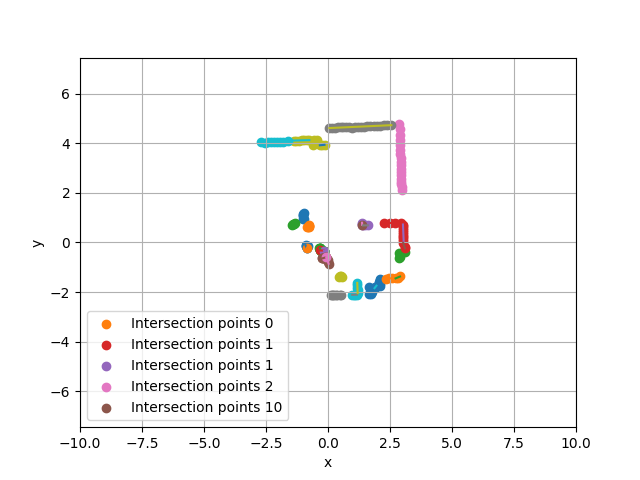

In [26]:
fig3 = plt.figure()
ax3 = fig3.gca()

for i, (cluster, lines, intersection_point) in enumerate(zip(clusters, cluster_lines, intersection_points)):
    ax3.scatter(cluster[:,0], cluster[:,1])
    for line_bounds, point_set in lines:
        ax3.plot(line_bounds[:, 0], line_bounds[:, 1])

    if len(intersection_point) > 0:
        for points, _ in intersection_point:
            ax3.scatter(points[:,0], points[:, 1], label=f'Intersection points {i}')
ax3.grid()
ax3.legend()

format_axes(ax3, x_bounds=[-10, 10], y_bounds=[-10, 10])

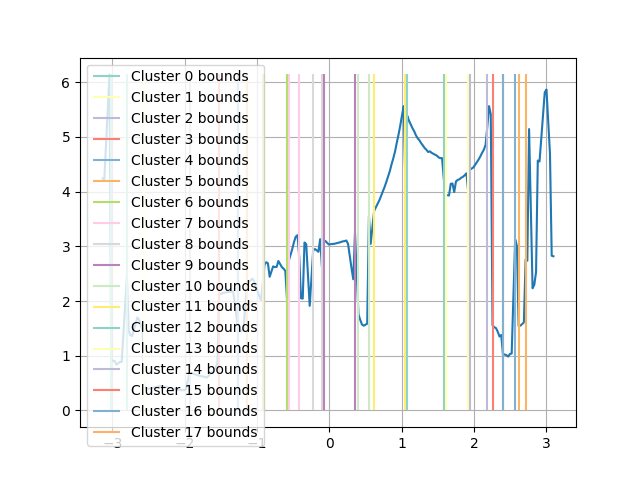

In [27]:
fig4 = plt.figure()
ax4 = fig4.gca()

ax4.plot(scan_theta_sorted, scan_r_sorted)

cmap = matplotlib.colormaps['Set3']

for i, (lower_bound, upper_bound) in enumerate(cluster_bound_pairs):
    ax4.vlines(
        x=[scan_theta_sorted[lower_bound], scan_theta_sorted[upper_bound]],
        ymin=0,
        ymax=np.max(scan_r_sorted),
        colors=cmap(i % cmap.N),
        label=f'Cluster {i} bounds'
    )

ax4.grid()
ax4.legend()

In [179]:
def cluster_scan(scan_r, scan_theta, scan_points,
                max_neighbour_distance = 0.03, min_points = 5):

    # Sort point by angle
    scan_sorted_index = np.argsort(scan_theta)

    # scan_r_sorted = scan_r[scan_sorted_index]
    # scan_theta_sorted = scan_theta[scan_sorted_index]

    scan_points_sorted = scan_points[scan_sorted_index]

    scan_points_diff = np.roll(scan_points_sorted, -1, axis=0) - scan_points_sorted

    scan_points_diff_distance = np.sqrt(np.sum(np.power(scan_points_diff, 2), axis=-1))

    cluster_bound_index = np.concatenate(
        [
            [0],
            np.where(scan_points_diff_distance > max_neighbour_distance)[0],
            [len(scan_points_diff_distance)],
        ],
        axis=0,
    )

    cluster_bound_pair = np.stack(
        [cluster_bound_index[:-1], cluster_bound_index[1:]], axis=-1
    )

    # Loop back
    if len(cluster_bound_pair) > 1:
        if scan_points_diff_distance[-1] <= max_neighbour_distance:
            # Fuse first and last cluster
            cluster_bound_pair[0,0] = cluster_bound_pair[-1,0] - len(scan_points_diff)
            cluster_bound_pair = cluster_bound_pair[:-1,:]

    cluster_size = np.diff(cluster_bound_pair, axis=-1)[..., 0]

    valid_cluster_mask = cluster_size > min_points

    filtered_cluster_bound_pair = cluster_bound_pair[valid_cluster_mask]

    return scan_sorted_index, filtered_cluster_bound_pair


def get_cluster_lines(sorted_points, max_angle_difference_radians: Number, min_line_points: int, line_segment_inlier_threshold: Number, merge_endpoint_distance_threshold: Number = 0):

    rolled_points = np.roll(sorted_points, -1, axis=0)

    sorted_direction = rolled_points - sorted_points
    sorted_direction_unit = np.divide(sorted_direction, np.expand_dims(np.linalg.norm(sorted_direction, axis=-1), axis=-1))

    rolled_sorted_direction_unit = np.roll(sorted_direction_unit, -1, axis=0)
    sorted_direction_cross = np.cross(rolled_sorted_direction_unit, sorted_direction_unit)
    sorted_direction_dot = np.sum(np.multiply(rolled_sorted_direction_unit, sorted_direction_unit), axis=-1)

    sorted_angle_difference = np.arctan2(sorted_direction_cross,sorted_direction_dot)

    cluster_member_mask = np.abs(sorted_angle_difference) <= max_angle_difference_radians
    bound_mask = np.diff(cluster_member_mask.astype(int), axis=0, prepend=0)
    bound_start_mask = bound_mask > 0
    bound_end_mask = bound_mask < 0

    derivative_count = 2
    
    cluster_bound_pair = np.stack([
        np.where(bound_start_mask)[0], 
        np.where(bound_end_mask)[0] + derivative_count, 
    ], axis=-1)

    if len(cluster_bound_pair) > 1:
        if cluster_member_mask[-1] and cluster_member_mask[0]:
            # Fuse first and last cluster
            cluster_bound_pair[0,0] = cluster_bound_pair[-1,0] - len(sorted_angle_difference)
            cluster_bound_pair = cluster_bound_pair[:-1,:]

    cluster_size = np.diff(cluster_bound_pair, axis=-1)[..., 0]

    valid_cluster_mask = cluster_size >= min_line_points

    filtered_cluster_bound_pair = cluster_bound_pair[valid_cluster_mask]

    clusters = []

    for lower_bound, upper_bound in filtered_cluster_bound_pair:

        line_points = np.take(sorted_points, range(lower_bound, upper_bound), axis=0, mode='wrap')
        try:
            line_slope_intercept = fit_line(line_points)
        except ValueError:
            continue
        line_p, line_v_hat = slope_intercept_to_vector_form(line_slope_intercept)
        line_segment = line_to_segment(line_points, line_p, line_v_hat, line_segment_inlier_threshold)
        # To segment
        if line_segment is not None:
            clusters.append((line_segment, line_points, line_v_hat))

    if merge_endpoint_distance_threshold != 0:
    # Merge consecutive cluster
    # If close enough in segment end points and angle

        cluster_count = len(clusters)
        if cluster_count == 0:
            return clusters

        cluster_lines, cluster_points, cluster_v_hat = list(zip(*clusters))

        cluster_v_hat_np = np.concatenate(cluster_v_hat, axis=0)

        cluster_angle_difference = np.arccos(np.abs(np.sum(np.multiply(np.expand_dims(cluster_v_hat_np, axis=0), np.expand_dims(cluster_v_hat_np, axis=1)), -1)))
        cluster_angle_merge_mask = cluster_angle_difference <= max_angle_difference_radians
        # print(f'{cluster_angle_difference.shape=}')

        cluster_lines_packed = np.concatenate(cluster_lines, axis=0)

        cluster_end_point_distances = np.sqrt(np.sum(np.power(np.expand_dims(cluster_lines_packed, axis=0) - np.expand_dims(cluster_lines_packed, axis=1),2), axis=-1))
        cluser_distance_merge_mask = cluster_end_point_distances <= merge_endpoint_distance_threshold        
        # print(f'{cluser_distance_merge_mask.shape=}')

        # Collapse 2 x 2 into 1x1 block
        cluser_distance_merge_mask_collapse = np.logical_or(cluser_distance_merge_mask[::2], cluser_distance_merge_mask[1::2])
        cluser_distance_merge_mask_collapse = np.logical_or(cluser_distance_merge_mask_collapse[:,::2], cluser_distance_merge_mask_collapse[:,1::2])
        # print(f'{cluser_distance_merge_mask_collapse.shape=}')

        cluster_merge_mask = np.logical_and(cluster_angle_merge_mask, cluser_distance_merge_mask_collapse)
        # print(f'{cluster_merge_mask.shape=}')

        disjoint_lines = UnionFind()

        for i in range(cluster_count):
            disjoint_lines.make_set(i)

        for i in range(cluster_count):
            for j in range(cluster_count):
                if(j >= i):
                    # Skip half triangle
                    break

                # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=}')
                if cluster_merge_mask[j,i]:
                    # Combine sets
                    # print(f'[{i=},{j=}] {similar_line_matrix[j,i]=} Pass')
                    disjoint_lines.union(i,j)

        set_roots = disjoint_lines.get_roots()
        
        clusters = []
        for root in set_roots:
            refit_points = []
            for i in range(cluster_count):
                if cluster_merge_mask[root][i]:
                    refit_points.append(cluster_points[i])

            if len(refit_points) <= 1:
                clusters.append((cluster_lines[root], cluster_points[root]))
                continue

            refit_points = np.concatenate(refit_points, axis=0)
            try:
                line_slope_intercept = fit_line(refit_points)
            except ValueError:
                continue
            line_p, line_v_hat = slope_intercept_to_vector_form(line_slope_intercept)
            line_segment = line_to_segment(refit_points, line_p, line_v_hat, line_segment_inlier_threshold)
            # To segment
            if line_segment is not None:
                clusters.append((line_segment, refit_points))
    else:
        clusters = [ (line, points) for line, points, _ in clusters ]

    return clusters
    # return clusters, sorted_angle_difference, filtered_cluster_bound_pair


In [165]:
def get_corner_points_lines_consecutive(line_list: List[Tuple[np.ndarray, np.ndarray]], max_intersection_point_distance: Number):
    """Assume line in line_list are ordered consecutively (i.e intersection only tested on consecutive pairs)
    Parameters
    ---------
    line_list:  List[Tuple[float np.ndarray[2, 2], float np.ndarray[N, 2]]]
        list of tuple of line segment (2 end points) and point set defining the line segment

    max_intersection_point_distance: Number
        distance to accept intersection point. reject if intersection is too far away
    
    Returns
    -------
    intersection_list: List[Tuple[float np.ndarray[1,2], int, int]]
        list of (intersection_point, line_1 index, line_2 index)

    """


    # line_list is list of line segment and point set
    M = len(line_list)
    if M < 2:
        return []
    lines, point_sets = list(zip(*line_list))

    print(lines)
    intersection_points = []
    for i in range(M):
        line_1 = lines[i]
        line_2 = lines[(i + 1) % M]

        line_1_p, line_1_v = line_vector_form_from_line_segment(np.expand_dims(line_1[0],0), np.expand_dims(line_1[1],0))
        line_2_p, line_2_v = line_vector_form_from_line_segment(np.expand_dims(line_2[0],0), np.expand_dims(line_2[1],0))

        intersection_point = line_line_intersection(line_1_p, line_1_v, line_2_p, line_2_v)

        if intersection_point is None: 
            continue

        # intersection
        line_packed = np.concatenate(
            [line_1, line_2], axis=0
        )

        intersection_point_distance = np.sqrt(np.sum(np.power(intersection_point - line_packed, 2), axis=-1))
        print(intersection_point_distance)
        if np.min(intersection_point_distance) > max_intersection_point_distance:
            continue

        intersection_points.append((intersection_point, (i, i+1)))

    return intersection_points


In [180]:
cluster_lines = []
for c in clusters:

    cluster_line = get_cluster_lines(c, 15*math.pi/180, 2, 0.1, merge_endpoint_distance_threshold=0.15)
    if cluster_line is not None:
        cluster_lines.append(cluster_line)

    # print(len(c))
    # print(get_cluster_lines(c, 10 * math.pi/180, 2))

/tmp/ipykernel_985533/1062610639.py:109: RuntimeWarning: invalid value encountered in arccos
  cluster_angle_difference = np.arccos(np.abs(np.sum(np.multiply(np.expand_dims(cluster_v_hat_np, axis=0), np.expand_dims(cluster_v_hat_np, axis=1)), -1)))


In [169]:
get_cluster_lines(clusters[10], 10*math.pi/180, 2, 0.1)

[(array([[1.41386383, 0.68460189],
         [1.61536811, 0.68834523]]),
  array([[1.61536384, 0.68857521],
         [1.50730133, 0.68584156],
         [1.41385889, 0.68486786]])),
 (array([[1.37340684, 0.79257785],
         [1.37724966, 0.70862913]]),
  array([[1.37740195, 0.70863611],
         [1.37487125, 0.7497232 ],
         [1.37375081, 0.7925936 ]]))]

In [170]:
cluster_lines[10]

[((array([[1.41386383, 0.68460189],
          [1.61536811, 0.68834523]]),
   array([[1.37340684, 0.79257785],
          [1.37724966, 0.70862913]])),
  array([[1.61536384, 0.68857521],
         [1.50730133, 0.68584156],
         [1.41385889, 0.68486786]])),
 ((array([[1.41386383, 0.68460189],
          [1.61536811, 0.68834523]]),
   array([[1.37340684, 0.79257785],
          [1.37724966, 0.70862913]])),
  array([[1.37740195, 0.70863611],
         [1.37487125, 0.7497232 ],
         [1.37375081, 0.7925936 ]]))]

In [171]:
cluster_lines[9][0]

((array([[ 3.01684834,  0.72147371],
         [ 3.05598071, -0.01899836]]),
  array([[2.26804103, 0.78234221],
         [2.94575029, 0.78293933]])),
 array([[ 3.03293252, -0.02021641],
        [ 3.03951883,  0.05407923],
        [ 3.03933501,  0.12730761],
        [ 3.0393815 ,  0.20069018],
        [ 3.04064202,  0.27441826],
        [ 3.04309082,  0.34866446],
        [ 3.03975987,  0.42263603],
        [ 3.0405488 ,  0.4976179 ],
        [ 3.03751755,  0.57251102],
        [ 3.02676916,  0.64629263],
        [ 3.02200794,  0.72174639]]))

In [109]:
rolled_points = np.roll(clusters[9], -1, 0)
direction = rolled_points - clusters[9]
direction_unit = np.divide(direction, np.expand_dims(np.linalg.norm(direction,axis=-1), -1))

In [110]:
np.linalg.norm(direction,axis=-1)

array([0.07533666, 0.16082181, 0.07458701, 0.0732286 , 0.07338259,
       0.07373886, 0.07428657, 0.07404653, 0.07498602, 0.07495444,
       0.0745604 , 0.07560383, 0.09531809, 0.23391236, 0.23139073,
       0.21267685, 1.31732779])

In [111]:
direction_unit

array([[-6.62310202e-02,  9.97804315e-01],
       [-3.69457164e-01,  9.29247762e-01],
       [ 8.83037565e-02,  9.96093593e-01],
       [-2.51023114e-03,  9.99996849e-01],
       [ 6.33551165e-04,  9.99999799e-01],
       [ 1.70943657e-02,  9.99853881e-01],
       [ 3.29641982e-02,  9.99456533e-01],
       [-4.49844991e-02,  9.98987685e-01],
       [ 1.05209890e-02,  9.99944653e-01],
       [-4.04412865e-02,  9.99181917e-01],
       [-1.44156763e-01,  9.89554863e-01],
       [-6.29758987e-02,  9.98015048e-01],
       [-7.99996398e-01,  6.00004802e-01],
       [-9.99339981e-01,  3.63263343e-02],
       [-9.99963885e-01, -8.49876775e-03],
       [-9.99493997e-01, -3.18080181e-02],
       [ 6.29527966e-01, -7.76977824e-01]])

In [112]:
direction_angle = np.arctan2(direction_unit[:,1], direction_unit[:,0])
rolled_direction_angle = np.roll(direction_angle, -1, 0)

direction_angle

array([ 1.63707586,  1.94922111,  1.48237741,  1.57330656,  1.57016278,
        1.55370113,  1.53782616,  1.61579601,  1.56027514,  1.61124864,
        1.71545711,  1.63381393,  2.49808554,  3.10525833, -3.13309378,
       -3.10977927, -0.88985079])

In [113]:
angle_diff = rolled_direction_angle - direction_angle
t = 2*math.pi - angle_diff
angle_diff_new = np.where(np.abs(angle_diff) < np.abs(t), angle_diff, t)

In [114]:
angle_diff

array([ 3.12145249e-01, -4.66843706e-01,  9.09291537e-02, -3.14378499e-03,
       -1.64616472e-02, -1.58749728e-02,  7.79698559e-02, -5.55208679e-02,
        5.09735013e-02,  1.04208464e-01, -8.16431822e-02,  8.64271615e-01,
        6.07172783e-01, -6.23835211e+00,  2.33145141e-02,  2.21992848e+00,
        2.52692665e+00])

In [115]:
t

array([ 5.97104006,  6.75002901,  6.19225615,  6.28632909,  6.29964695,
        6.29906028,  6.20521545,  6.33870618,  6.23221181,  6.17897684,
        6.36482849,  5.41891369,  5.67601252, 12.52153742,  6.25987079,
        4.06325683,  3.75625865])

In [116]:
angle_diff_new

array([ 3.12145249e-01, -4.66843706e-01,  9.09291537e-02, -3.14378499e-03,
       -1.64616472e-02, -1.58749728e-02,  7.79698559e-02, -5.55208679e-02,
        5.09735013e-02,  1.04208464e-01, -8.16431822e-02,  8.64271615e-01,
        6.07172783e-01, -6.23835211e+00,  2.33145141e-02,  2.21992848e+00,
        2.52692665e+00])

In [117]:
rolled_sorted_direction_unit = np.roll(direction_unit, -1, axis=0)
sorted_direction_cross = np.cross(rolled_sorted_direction_unit, direction_unit)
sorted_direction_dot = np.sum(np.multiply(rolled_sorted_direction_unit, direction_unit), axis=-1)

sorted_angle_difference = np.arctan2(sorted_direction_cross,sorted_direction_dot)

In [118]:
sorted_angle_difference

array([-0.31214525,  0.46684371, -0.09092915,  0.00314378,  0.01646165,
        0.01587497, -0.07796986,  0.05552087, -0.0509735 , -0.10420846,
        0.08164318, -0.86427162, -0.60717278, -0.0448332 , -0.02331451,
       -2.21992848, -2.52692665])

In [119]:
sorted_direction_cross

array([-0.30710093,  0.45006998, -0.0908039 ,  0.00314378,  0.0164609 ,
        0.01587431, -0.07789088,  0.05549235, -0.05095143, -0.10401996,
        0.08155251, -0.7606226 , -0.57054785, -0.04481818, -0.0233124 ,
       -0.79660871, -0.57668569])

In [120]:
sorted_direction_dot

array([ 0.95167695,  0.89299329,  0.99586879,  0.99999506,  0.99986451,
        0.999874  ,  0.99696189,  0.99845911,  0.99870113,  0.99457521,
        0.99666905,  0.64919431,  0.82126436,  0.99899516,  0.99972823,
       -0.6044953 , -0.81696611])

In [121]:
direction.shape

(17, 2)

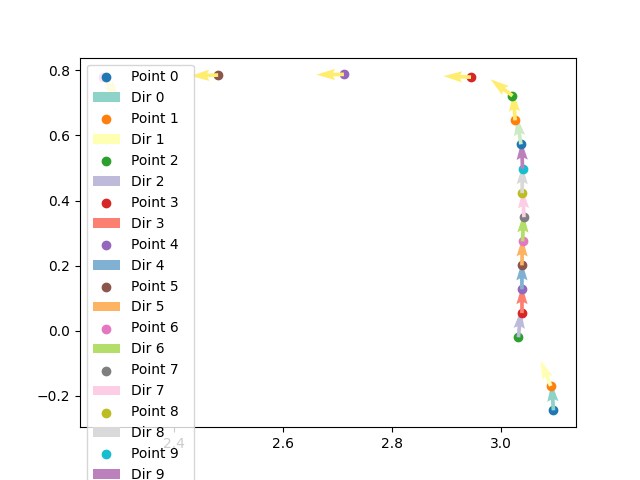

In [122]:
plt.figure()
for i in range(len(clusters[9])):
    plt.scatter(clusters[9][i,0], clusters[9][i,1], label=f'Point {i}')
    # plt.scatter(rolled_points[i,0], rolled_points[i,1], label=f'Point {i}')
    # plt.quiver([clusters[10][i]], direction[i,0], direction[i,1])
    plt.quiver(clusters[9][i,0], clusters[9][i,1], direction[i,0], direction[i,1], color=matplotlib.colormaps['Set3'](i), label=f'Dir {i}')
    # plt.quiver(clusters[10][i,0], clusters[10][i,1], rolled_sorted_direction_unit[i,0], rolled_sorted_direction_unit[i,1], color=matplotlib.colormaps['Set3'](i), label=f'Dir {i}')
# plt.quiver(clusters[10][:,0], clusters[10][:,1], direction[:,0], direction[:,1])

plt.legend()

In [123]:
sorted_angle_difference = np.array([0.01487156, 0.58816753, 0.93153306, 0.03538594, 2.00345994,
       2.70976728])

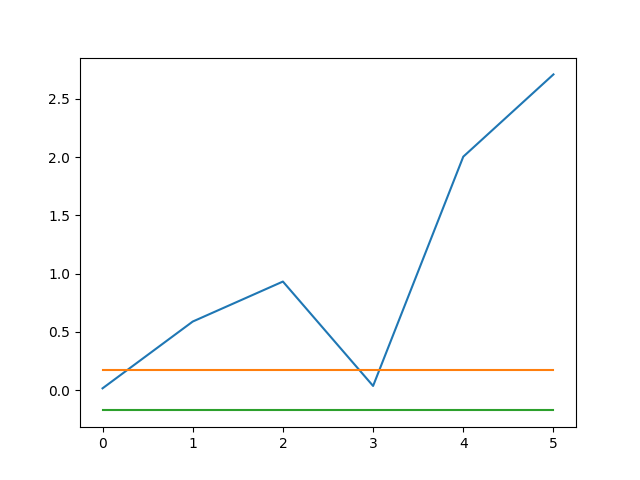

In [124]:
plt.figure()
# plt.plot(np.arange(len(cluster_lines[10][1])), np.abs(cluster_lines[10][1]))
plt.plot(np.arange(len(sorted_angle_difference)), sorted_angle_difference)
plt.plot(np.arange(len(sorted_angle_difference)), 10 * math.pi/180 * np.ones_like(sorted_angle_difference))
plt.plot(np.arange(len(sorted_angle_difference)), -10 * math.pi/180 * np.ones_like(sorted_angle_difference))
# plt.plot(np.arange(len(cluster_lines[9][1])), np.roll(np.arctan2(direction_unit[:,1], direction_unit[:,0]), -1, 0) - np.arctan2(direction_unit[:,1], direction_unit[:,0]))

In [125]:
line_membership = np.abs(sorted_angle_difference) <= 10*math.pi/180

In [126]:
line_membership

array([ True, False, False,  True, False, False])

In [127]:
bound_mask = np.diff(line_membership.astype(int), axis=0, prepend=0)
# bound_mask = np.diff(np.concatenate([[False], line_membership]).astype(int), axis=0)
bound_mask

array([ 1, -1,  0,  1, -1,  0])

In [128]:
sorted_angle_difference

array([0.01487156, 0.58816753, 0.93153306, 0.03538594, 2.00345994,
       2.70976728])

In [129]:
sorted_angle_difference[0:1]

array([0.01487156])

In [130]:
sorted_angle_difference[3:4]

array([0.03538594])

In [131]:
len(lines)

0

In [132]:
len(cluster_lines)

18

In [133]:
cluster_lines[2][0]

(array([[-0.24501835, -0.64873334],
        [-0.07232438, -0.59716994]]),
 array([[-0.24518442, -0.64817715],
        [-0.22586881, -0.64351165],
        [-0.20661362, -0.63734668],
        [-0.18807359, -0.63159263],
        [-0.17019466, -0.62628651],
        [-0.15292028, -0.62146229],
        [-0.13619351, -0.61715096],
        [-0.11938032, -0.61043614],
        [-0.10347486, -0.60623258],
        [-0.0879861 , -0.60261059],
        [-0.07249093, -0.59661216]]))

In [134]:
len(intersection_points)

18

In [135]:
get_corner_points_lines_consecutive(cluster_lines[10], 0.02)

(array([[1.41386383, 0.68460189],
       [1.61536811, 0.68834523]]), array([[1.37340684, 0.79257785],
       [1.37724966, 0.70862913]]))
[0.03549025 0.2370293  0.1087489  0.02471228]
[0.1087489  0.02471228 0.03549025 0.2370293 ]


[]

In [181]:
intersection_points = []
for i, line in enumerate(cluster_lines):
    intersection_points.append(get_corner_points_lines_consecutive(line, 0.05))

(array([[-0.90603462, -0.11476107],
       [-0.89055682, -0.15664319]]), array([[-0.86196854, -0.21690702],
       [-0.81939313, -0.16476653]]))
[0.11457616 0.06992558 0.00687623 0.07419114]
[0.00687623 0.07419114 0.11457616 0.06992558]
(array([[-0.31620465, -0.24320816],
       [-0.31076229, -0.32059117]]), array([[-0.29036586, -0.32838806],
       [-0.16224686, -0.32813527]]))
[0.08542956 0.0078554  0.01984536 0.1479646 ]
[0.01984536 0.1479646  0.08542956 0.0078554 ]
(array([[-0.24501835, -0.64873334],
       [-0.07232438, -0.59716994]]), array([[-0.07307545, -0.59682828],
       [ 0.02432828, -0.86026206]]))
[0.17964044 0.00058716 0.00054338 0.28032109]
[0.00054338 0.28032109 0.17964044 0.00058716]
(array([[ 0.97665698, -2.11298241],
       [ 1.16536451, -2.10692575]]), array([[ 1.17962097, -1.63370668],
       [ 1.19655188, -2.04510907]]))
[0.22250893 0.03370424 0.47253752 0.06078688]
[0.47253752 0.06078688 0.22250893 0.03370424]
(array([[ 1.87585545, -1.84493255],
       [ 1.95491

In [182]:
len(intersection_points[0][0])

2

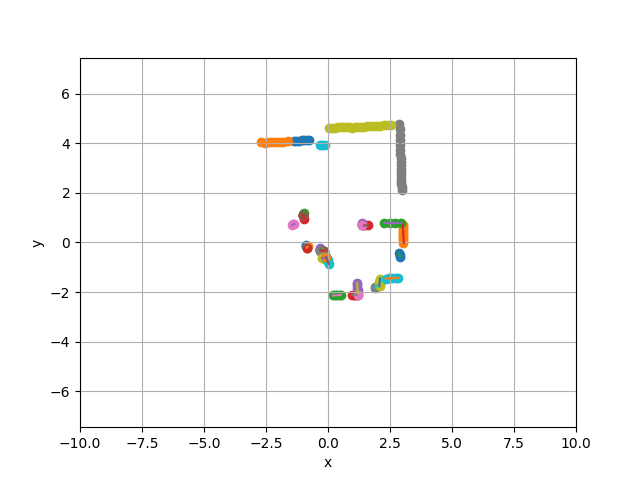

In [183]:
fig5 = plt.figure()
ax5 = fig5.gca()

for i, (cluster, lines, intersection_point) in enumerate(zip(clusters, cluster_lines, intersection_points)):
    # ax5.scatter(cluster[:,0], cluster[:,1])
    # if i != 9 and i != 10:
    #     continue
    # print(lines)
    # print(len(lines))

    

    lines_l = lines

    for line_bounds, point_set in lines_l:
        ax5.plot(line_bounds[:, 0], line_bounds[:, 1])
        ax5.scatter(point_set[:,0], point_set[:,1], label=f'Point set{i}')

    if len(intersection_point) > 0:
        for (points, _) in intersection_point:
            ax5.scatter(points[:,0], points[:, 1], label=f'Intersection points {i}')
ax5.grid()
# ax5.legend()

format_axes(ax5, x_bounds=[-10, 10], y_bounds=[-10, 10])

In [146]:
# Landmark
import gtsam


In [147]:
isam2 = gtsam.ISAM2()

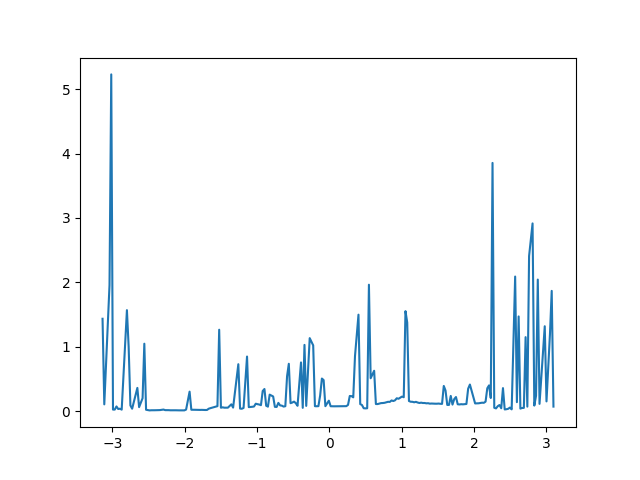

In [51]:
fig2 = plt.figure()
ax2 = fig2.gca()

plt.plot(scan_theta_sorted, scan_points_diff_distance)
# plt.plot(np.arange(len(scan_points_diff_distance)), scan_points_diff_distance)

In [21]:
def get_clusters(distances, distance_threshold):
    """Distance-based clustering

    Parameters
    ------

    Returns
    -------
    sorted_indices
    cluster_bound_pair: array N x 2 of index bounds
    """
    sorted_indices = np.argsort(distances)
    sorted_distances = distances[sorted_indices]

    sorted_distances_diff = np.diff(sorted_distances)
    cluster_bound_index = np.concatenate(
        [
            [0],
            np.where(sorted_distances_diff > distance_threshold)[0],
            [len(distances)],
        ],
        axis=0,
    )

    cluster_bound_pair = np.stack(
        [cluster_bound_index[:-1], cluster_bound_index[1:]], axis=-1
    )

    return sorted_indices, cluster_bound_pair

In [ ]:
scan_clusters = get_clusters()

In [461]:
test_points = []

# Front
test_points.append(
    np.stack([1.5*np.ones(10), np.linspace(-0.5, 0.5, 10)], axis=-1)
)

# Back
test_points.append(
    np.stack([-1.5*np.ones(10), np.linspace(-0.25, 0.75, 10)], axis=-1)
)

# Top Right
test_points.append(
    np.stack([1*np.ones(5), np.linspace(0.75, 1.0, 5)], axis=-1)
)

test_points.append(
    np.stack([np.linspace(1.0, 1.25, 5), 0.75*np.ones(5), ], axis=-1)
)

# Bot left
test_points.append(
    np.stack([-1*np.ones(5), np.linspace(-0.75, -0.25, 5)], axis=-1)
)

test_points.append(
    np.stack([np.linspace(-1.0, -0.75, 5), -0.75*np.ones(5), ], axis=-1)
)

In [462]:
test_points = np.concatenate(test_points, axis=0)

In [463]:
test_points

array([[ 1.5       , -0.5       ],
       [ 1.5       , -0.38888889],
       [ 1.5       , -0.27777778],
       [ 1.5       , -0.16666667],
       [ 1.5       , -0.05555556],
       [ 1.5       ,  0.05555556],
       [ 1.5       ,  0.16666667],
       [ 1.5       ,  0.27777778],
       [ 1.5       ,  0.38888889],
       [ 1.5       ,  0.5       ],
       [-1.5       , -0.25      ],
       [-1.5       , -0.13888889],
       [-1.5       , -0.02777778],
       [-1.5       ,  0.08333333],
       [-1.5       ,  0.19444444],
       [-1.5       ,  0.30555556],
       [-1.5       ,  0.41666667],
       [-1.5       ,  0.52777778],
       [-1.5       ,  0.63888889],
       [-1.5       ,  0.75      ],
       [ 1.        ,  0.75      ],
       [ 1.        ,  0.8125    ],
       [ 1.        ,  0.875     ],
       [ 1.        ,  0.9375    ],
       [ 1.        ,  1.        ],
       [ 1.        ,  0.75      ],
       [ 1.0625    ,  0.75      ],
       [ 1.125     ,  0.75      ],
       [ 1.1875    ,

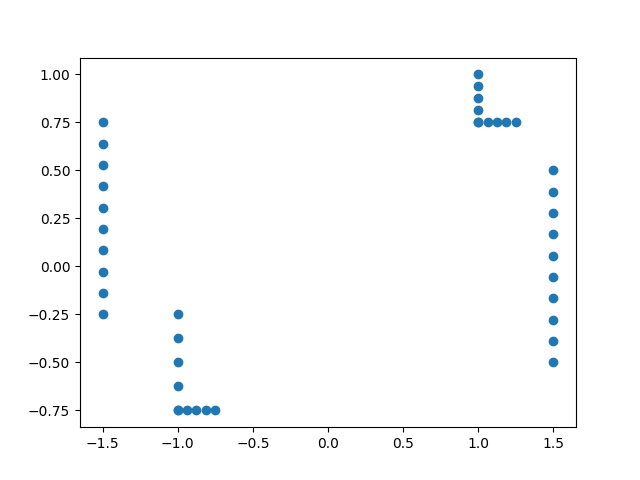

In [464]:
plt.figure()
plt.scatter(test_points[:,0], test_points[:,1])

In [465]:
test_r, test_theta = points_to_distance_angle(test_points)

In [474]:
test_clusters_sorted_index, test_clusters_bounds = cluster_scan(test_r, test_theta, test_points, 0.2, 3)

sorted_test_r = test_r[test_clusters_sorted_index]
sorted_test_theta = test_theta[test_clusters_sorted_index]
sorted_test_points = test_points[test_clusters_sorted_index]

test_clusters = []
for lower_bound, upper_bound in test_clusters_bounds:
    test_clusters.append(sorted_test_points.take(range(lower_bound,upper_bound), axis=0, mode='wrap'))

[0.11111111 0.11111111 0.5        0.125      0.125      0.125
 0.125      0.         0.0625     0.0625     0.0625     0.0625
 2.26384628 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111 0.35355339 0.0625
 0.0625     0.0625     0.0625     0.         0.0625     0.0625
 0.0625     0.0625     2.51246891 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111 0.11111111]
[ 1  0 -1  1  0  0  0  0  0  0  0  0 -1  1  0  0  0  0  0  0  0  0 -1  1
  0  0  0  0  0  0  0  0 -1  1  0  0  0  0  0  0]
[ True False False  True False False False False False False False False
 False  True False False False False False False False False False  True
 False False False False False False False False False  True False False
 False False False False]
[False False  True False False False False False False False False False
  True False False False False False False False False False  True False
 False False False False False False False False  True 

In [467]:
sorted_test_points_diff = np.roll(sorted_test_points, -1, axis=0) - sorted_test_points

In [468]:
test_points_diff_distance = np.sqrt(np.sum(np.power(sorted_test_points_diff, 2), axis=-1))

In [469]:
test_points_diff_distance

array([0.11111111, 0.11111111, 0.5       , 0.125     , 0.125     ,
       0.125     , 0.125     , 0.        , 0.0625    , 0.0625    ,
       0.0625    , 0.0625    , 2.26384628, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.35355339, 0.0625    , 0.0625    ,
       0.0625    , 0.0625    , 0.        , 0.0625    , 0.0625    ,
       0.0625    , 0.0625    , 2.51246891, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111])

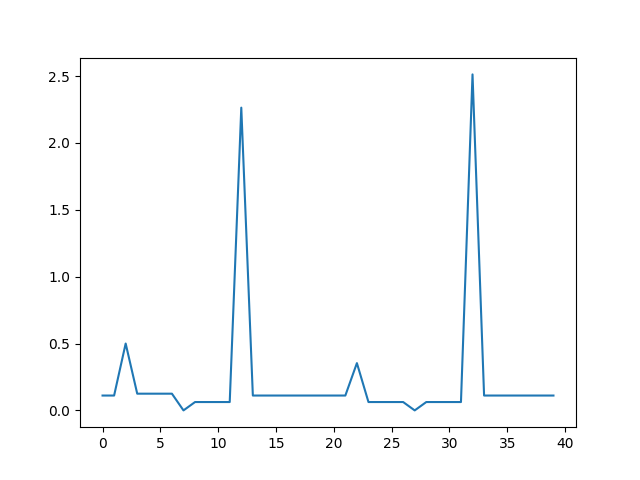

In [470]:
plt.figure()
plt.plot(np.arange(len(test_points_diff_distance)), test_points_diff_distance)

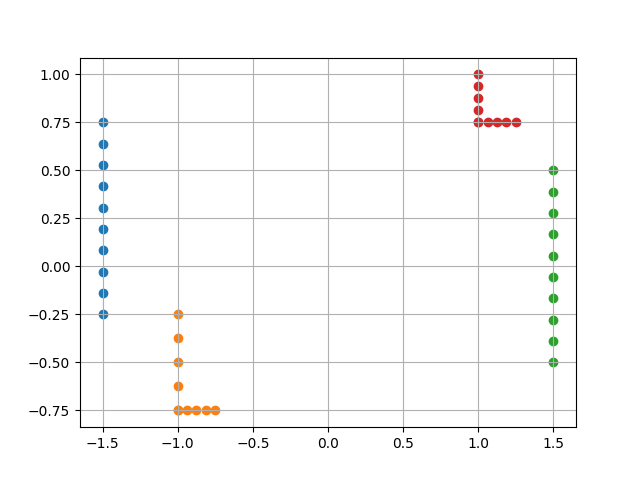

In [475]:
plt.figure()
for cluster in test_clusters:
    plt.scatter(cluster[:,0], cluster[:,1])
# for i,p in enumerate(sorted_test_points[:15]):
#     plt.scatter([p[0]], [p[1]], label=f'Point {i}')
plt.grid()
# plt.legend()

In [11]:
def cluster_scan(scan_r, scan_theta, scan_points,
                max_neighbour_distance = 0.03, min_points = 5):

    # Sort point by angle
    scan_sorted_index = np.argsort(scan_theta)

    # scan_r_sorted = scan_r[scan_sorted_index]
    # scan_theta_sorted = scan_theta[scan_sorted_index]

    scan_points_sorted = scan_points[scan_sorted_index]

    scan_points_diff = np.roll(scan_points_sorted, -1, axis=0) - scan_points_sorted

    scan_points_diff_distance = np.sqrt(np.sum(np.power(scan_points_diff, 2), axis=-1))

    cluster_member_mask = scan_points_diff_distance <= max_neighbour_distance
    bound_mask = np.diff(cluster_member_mask.astype(int), axis=0, prepend=0)
    bound_start_mask = bound_mask > 0
    bound_end_mask = bound_mask < 0

    derivative_count = 1
    print(scan_points_diff_distance)
    print(bound_mask)
    print(bound_start_mask)
    print(bound_end_mask)

    print(np.where(bound_start_mask)[0])
    print(np.where(bound_end_mask)[0] + derivative_count)

    cluster_start = np.where(bound_start_mask)[0]
    cluster_end = np.where(bound_end_mask)[0] + derivative_count

    if len(cluster_start) != len(cluster_end):
        cluster_end = np.concatenate([cluster_end, [len(cluster_member_mask)]], axis=0)

    # Loop back
    cluster_bound_pair = np.stack([
        cluster_start, 
        cluster_end, 
    ], axis=-1)

    print(cluster_bound_pair)

    if len(cluster_bound_pair) > 1:
        if cluster_member_mask[-1] and cluster_member_mask[0]:
            # Fuse first and last cluster
            cluster_bound_pair[0,0] = cluster_bound_pair[-1,0] - len(cluster_member_mask)
            cluster_bound_pair = cluster_bound_pair[:-1,:]

    print(cluster_bound_pair)

    cluster_size = np.diff(cluster_bound_pair, axis=-1)[..., 0]

    valid_cluster_mask = cluster_size > min_points

    filtered_cluster_bound_pair = cluster_bound_pair[valid_cluster_mask]

    return scan_sorted_index, filtered_cluster_bound_pair